In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 8.4 MB/s 
     |████████████████████████████████| 190 kB 5.0 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7170, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 7170 (delta 49), reused 159 (delta 40), pack-reused 6988
Receiving objects: 100% (7170/7170), 13.42 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (5231/5231), done.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-24 10:42:46--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  9.23MB/s    in 34s     

2022-05-24 10:43:21 (9.11 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]

In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='DiceLoss', loss_w

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-24 10:43:25,043 - mmseg - INFO - Loaded 537 images
2022-05-24 10:43:38,356 - mmseg - INFO - Loaded 113 images
2022-05-24 10:43:38,360 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-24 10:43:38,791 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
2022-05-24 10:43:38,797 - mmseg - INFO - Start running, host: root@9a195bd9a3cd, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz
2022-05-24 10:43:38,799 - mmseg - INFO - Hooks will be executed in the following order

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.1 task/s, elapsed: 759s, ETA:     0s

2022-05-24 11:04:29,763 - mmseg - INFO - per class results:
2022-05-24 11:04:29,764 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.19 | 93.69 |
|  building  | 74.58 | 84.41 |
+------------+-------+-------+
2022-05-24 11:04:29,766 - mmseg - INFO - Summary:
2022-05-24 11:04:29,770 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.69 | 80.89 | 89.05 |
+-------+-------+-------+
2022-05-24 11:04:29,772 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9069, mIoU: 0.8089, mAcc: 0.8905, IoU.background: 0.8719, IoU.building: 0.7458, Acc.background: 0.9369, Acc.building: 0.8441
2022-05-24 11:05:11,275 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 6:10:01, time: 8.001, data_time: 7.613, memory: 3323, decode.loss_dice: 0.2247, decode.loss_lovasz: 0.2444, decode.acc_seg: 88.3491, loss: 0.4691
2022-05-24 11:05:50,431 - mmseg - INFO - Iter [1200/20000]	lr: 4.508e-05, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 11:23:32,306 - mmseg - INFO - per class results:
2022-05-24 11:23:32,307 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.83 | 93.24 |
|  building  | 78.52 | 89.62 |
+------------+-------+-------+
2022-05-24 11:23:32,309 - mmseg - INFO - Summary:
2022-05-24 11:23:32,312 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.07 | 83.68 | 91.43 |
+-------+-------+-------+
2022-05-24 11:23:32,313 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9207, mIoU: 0.8368, mAcc: 0.9143, IoU.background: 0.8883, IoU.building: 0.7852, Acc.background: 0.9324, Acc.building: 0.8962
2022-05-24 11:24:11,613 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 5:45:33, time: 7.701, data_time: 7.313, memory: 3323, decode.loss_dice: 0.1876, decode.loss_lovasz: 0.2117, decode.acc_seg: 90.3098, loss: 0.3993
2022-05-24 11:24:52,922 - mmseg - INFO - Iter [2200/20000]	lr: 5.340e-05, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 11:42:32,783 - mmseg - INFO - per class results:
2022-05-24 11:42:32,784 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.14 | 93.17 |
|  building  | 79.24 | 90.56 |
+------------+-------+-------+
2022-05-24 11:42:32,785 - mmseg - INFO - Summary:
2022-05-24 11:42:32,787 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.32 | 84.19 | 91.86 |
+-------+-------+-------+
2022-05-24 11:42:32,790 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9232, mIoU: 0.8419, mAcc: 0.9186, IoU.background: 0.8914, IoU.building: 0.7924, Acc.background: 0.9317, Acc.building: 0.9056
2022-05-24 11:43:11,897 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 5:24:37, time: 7.697, data_time: 7.311, memory: 3323, decode.loss_dice: 0.1776, decode.loss_lovasz: 0.1942, decode.acc_seg: 91.1666, loss: 0.3718
2022-05-24 11:43:51,149 - mmseg - INFO - Iter [3200/20000]	lr: 5.040e-05, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 730s, ETA:     0s

2022-05-24 12:01:33,157 - mmseg - INFO - per class results:
2022-05-24 12:01:33,159 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.04 | 94.47 |
|  building  | 80.42 | 89.72 |
+------------+-------+-------+
2022-05-24 12:01:33,161 - mmseg - INFO - Summary:
2022-05-24 12:01:33,164 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.93 | 85.23 | 92.09 |
+-------+-------+-------+
2022-05-24 12:01:33,167 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9293, mIoU: 0.8523, mAcc: 0.9209, IoU.background: 0.9004, IoU.building: 0.8042, Acc.background: 0.9447, Acc.building: 0.8972
2022-05-24 12:02:12,465 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 5:04:38, time: 7.697, data_time: 7.310, memory: 3323, decode.loss_dice: 0.1822, decode.loss_lovasz: 0.1975, decode.acc_seg: 90.6301, loss: 0.3797
2022-05-24 12:02:51,733 - mmseg - INFO - Iter [4200/20000]	lr: 4.740e-05, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 12:20:38,870 - mmseg - INFO - per class results:
2022-05-24 12:20:38,871 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.05 | 94.38 |
|  building  | 80.49 | 89.95 |
+------------+-------+-------+
2022-05-24 12:20:38,872 - mmseg - INFO - Summary:
2022-05-24 12:20:38,874 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.94 | 85.27 | 92.16 |
+-------+-------+-------+
2022-05-24 12:20:38,878 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9294, mIoU: 0.8527, mAcc: 0.9216, IoU.background: 0.9005, IoU.building: 0.8049, Acc.background: 0.9438, Acc.building: 0.8995
2022-05-24 12:21:18,131 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 4:45:17, time: 7.700, data_time: 7.313, memory: 3323, decode.loss_dice: 0.1628, decode.loss_lovasz: 0.1809, decode.acc_seg: 91.6781, loss: 0.3437
2022-05-24 12:21:57,487 - mmseg - INFO - Iter [5200/20000]	lr: 4.440e-05, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 730s, ETA:     0s

2022-05-24 12:39:41,214 - mmseg - INFO - per class results:
2022-05-24 12:39:41,216 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.26 | 94.08 |
|  building  | 81.12 | 91.16 |
+------------+-------+-------+
2022-05-24 12:39:41,217 - mmseg - INFO - Summary:
2022-05-24 12:39:41,222 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.14 | 85.69 | 92.62 |
+-------+-------+-------+
2022-05-24 12:39:41,223 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9314, mIoU: 0.8569, mAcc: 0.9262, IoU.background: 0.9026, IoU.building: 0.8112, Acc.background: 0.9408, Acc.building: 0.9116
2022-05-24 12:40:20,330 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 4:25:53, time: 7.689, data_time: 7.303, memory: 3323, decode.loss_dice: 0.1733, decode.loss_lovasz: 0.1903, decode.acc_seg: 91.2531, loss: 0.3636
2022-05-24 12:40:59,518 - mmseg - INFO - Iter [6200/20000]	lr: 4.140e-05, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 730s, ETA:     0s

2022-05-24 12:58:40,543 - mmseg - INFO - per class results:
2022-05-24 12:58:40,545 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.54 |  94.7 |
|  building  | 81.36 | 90.37 |
+------------+-------+-------+
2022-05-24 12:58:40,547 - mmseg - INFO - Summary:
2022-05-24 12:58:40,549 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.3 | 85.95 | 92.54 |
+------+-------+-------+
2022-05-24 12:58:40,551 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9330, mIoU: 0.8595, mAcc: 0.9254, IoU.background: 0.9054, IoU.building: 0.8136, Acc.background: 0.9470, Acc.building: 0.9037
2022-05-24 12:59:19,604 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 4:06:30, time: 7.689, data_time: 7.304, memory: 3323, decode.loss_dice: 0.1405, decode.loss_lovasz: 0.1594, decode.acc_seg: 92.7973, loss: 0.2999
2022-05-24 12:59:58,951 - mmseg - INFO - Iter [7200/20000]	lr: 3.840e-05, eta: 4

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 730s, ETA:     0s

2022-05-24 13:17:41,163 - mmseg - INFO - per class results:
2022-05-24 13:17:41,164 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.83 | 95.99 |
|  building  | 81.31 | 88.13 |
+------------+-------+-------+
2022-05-24 13:17:41,166 - mmseg - INFO - Summary:
2022-05-24 13:17:41,168 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.45 | 86.07 | 92.06 |
+-------+-------+-------+
2022-05-24 13:17:41,172 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9345, mIoU: 0.8607, mAcc: 0.9206, IoU.background: 0.9083, IoU.building: 0.8131, Acc.background: 0.9599, Acc.building: 0.8813
2022-05-24 13:18:22,470 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 3:47:18, time: 7.712, data_time: 7.326, memory: 3323, decode.loss_dice: 0.1441, decode.loss_lovasz: 0.1637, decode.acc_seg: 92.7158, loss: 0.3078
2022-05-24 13:19:01,713 - mmseg - INFO - Iter [8200/20000]	lr: 3.540e-05, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 13:36:43,058 - mmseg - INFO - per class results:
2022-05-24 13:36:43,060 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.8 | 94.98 |
|  building  | 81.79 | 90.38 |
+------------+-------+-------+
2022-05-24 13:36:43,062 - mmseg - INFO - Summary:
2022-05-24 13:36:43,065 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.49 | 86.3 | 92.68 |
+-------+------+-------+
2022-05-24 13:36:43,067 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9349, mIoU: 0.8630, mAcc: 0.9268, IoU.background: 0.9080, IoU.building: 0.8179, Acc.background: 0.9498, Acc.building: 0.9038
2022-05-24 13:37:22,282 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 3:28:04, time: 7.701, data_time: 7.314, memory: 3323, decode.loss_dice: 0.1271, decode.loss_lovasz: 0.1486, decode.acc_seg: 93.5339, loss: 0.2758
2022-05-24 13:38:03,650 - mmseg - INFO - Iter [9200/20000]	lr: 3.240e-05, eta: 3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 730s, ETA:     0s

2022-05-24 13:55:42,521 - mmseg - INFO - per class results:
2022-05-24 13:55:42,523 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.07 | 95.84 |
|  building  | 81.92 | 89.04 |
+------------+-------+-------+
2022-05-24 13:55:42,524 - mmseg - INFO - Summary:
2022-05-24 13:55:42,527 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.64 | 86.49 | 92.44 |
+-------+-------+-------+
2022-05-24 13:55:42,530 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9364, mIoU: 0.8649, mAcc: 0.9244, IoU.background: 0.9107, IoU.building: 0.8192, Acc.background: 0.9584, Acc.building: 0.8904
2022-05-24 13:56:21,556 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 3:08:53, time: 7.688, data_time: 7.303, memory: 3323, decode.loss_dice: 0.1283, decode.loss_lovasz: 0.1496, decode.acc_seg: 93.2243, loss: 0.2780
2022-05-24 13:57:00,545 - mmseg - INFO - Iter [10200/20000]	lr: 2.940e-05,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 730s, ETA:     0s

2022-05-24 14:14:41,316 - mmseg - INFO - per class results:
2022-05-24 14:14:41,317 - mmseg - INFO - 
+------------+------+-------+
|   Class    | IoU  |  Acc  |
+------------+------+-------+
| background | 91.0 | 94.85 |
|  building  | 82.3 | 91.17 |
+------------+------+-------+
2022-05-24 14:14:41,321 - mmseg - INFO - Summary:
2022-05-24 14:14:41,322 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.66 | 86.65 | 93.01 |
+-------+-------+-------+
2022-05-24 14:14:41,325 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9366, mIoU: 0.8665, mAcc: 0.9301, IoU.background: 0.9100, IoU.building: 0.8230, Acc.background: 0.9485, Acc.building: 0.9117
2022-05-24 14:15:20,299 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 2:49:43, time: 7.694, data_time: 7.309, memory: 3323, decode.loss_dice: 0.1414, decode.loss_lovasz: 0.1516, decode.acc_seg: 93.1585, loss: 0.2930
2022-05-24 14:15:59,348 - mmseg - INFO - Iter [11200/20000]	lr: 2.640e-05, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 14:33:42,166 - mmseg - INFO - per class results:
2022-05-24 14:33:42,167 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.92 | 94.79 |
|  building  | 82.16 | 91.11 |
+------------+-------+-------+
2022-05-24 14:33:42,171 - mmseg - INFO - Summary:
2022-05-24 14:33:42,172 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 93.6 | 86.54 | 92.95 |
+------+-------+-------+
2022-05-24 14:33:42,174 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9360, mIoU: 0.8654, mAcc: 0.9295, IoU.background: 0.9092, IoU.building: 0.8216, Acc.background: 0.9479, Acc.building: 0.9111
2022-05-24 14:34:21,618 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 2:30:37, time: 7.704, data_time: 7.315, memory: 3323, decode.loss_dice: 0.1427, decode.loss_lovasz: 0.1519, decode.acc_seg: 93.1927, loss: 0.2947
2022-05-24 14:35:01,166 - mmseg - INFO - Iter [12200/20000]	lr: 2.340e-05, eta:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 14:52:45,406 - mmseg - INFO - per class results:
2022-05-24 14:52:45,408 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.23 | 95.56 |
|  building  | 82.43 | 90.08 |
+------------+-------+-------+
2022-05-24 14:52:45,411 - mmseg - INFO - Summary:
2022-05-24 14:52:45,413 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.79 | 86.83 | 92.82 |
+-------+-------+-------+
2022-05-24 14:52:45,418 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9379, mIoU: 0.8683, mAcc: 0.9282, IoU.background: 0.9123, IoU.building: 0.8243, Acc.background: 0.9556, Acc.building: 0.9008
2022-05-24 14:53:24,475 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 2:11:32, time: 7.701, data_time: 7.316, memory: 3323, decode.loss_dice: 0.1321, decode.loss_lovasz: 0.1538, decode.acc_seg: 92.9946, loss: 0.2859
2022-05-24 14:54:03,470 - mmseg - INFO - Iter [13200/20000]	lr: 2.040e-05,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 15:11:45,012 - mmseg - INFO - per class results:
2022-05-24 15:11:45,013 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.36 | 95.28 |
|  building  | 82.86 | 91.03 |
+------------+-------+-------+
2022-05-24 15:11:45,014 - mmseg - INFO - Summary:
2022-05-24 15:11:45,019 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.91 | 87.11 | 93.16 |
+-------+-------+-------+
2022-05-24 15:11:45,021 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9391, mIoU: 0.8711, mAcc: 0.9316, IoU.background: 0.9136, IoU.building: 0.8286, Acc.background: 0.9528, Acc.building: 0.9103
2022-05-24 15:12:24,343 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:52:27, time: 7.702, data_time: 7.314, memory: 3323, decode.loss_dice: 0.1253, decode.loss_lovasz: 0.1443, decode.acc_seg: 93.7135, loss: 0.2696
2022-05-24 15:13:03,655 - mmseg - INFO - Iter [14200/20000]	lr: 1.740e-05,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 730s, ETA:     0s

2022-05-24 15:30:46,845 - mmseg - INFO - per class results:
2022-05-24 15:30:46,846 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.38 | 95.42 |
|  building  | 82.82 | 90.75 |
+------------+-------+-------+
2022-05-24 15:30:46,848 - mmseg - INFO - Summary:
2022-05-24 15:30:46,853 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.91 | 87.1 | 93.09 |
+-------+------+-------+
2022-05-24 15:30:46,855 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9391, mIoU: 0.8710, mAcc: 0.9309, IoU.background: 0.9138, IoU.building: 0.8282, Acc.background: 0.9542, Acc.building: 0.9075
2022-05-24 15:31:28,029 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:33:23, time: 7.716, data_time: 7.331, memory: 3323, decode.loss_dice: 0.1241, decode.loss_lovasz: 0.1401, decode.acc_seg: 93.9526, loss: 0.2642
2022-05-24 15:32:07,180 - mmseg - INFO - Iter [15200/20000]	lr: 1.440e-05, eta:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 15:49:50,664 - mmseg - INFO - per class results:
2022-05-24 15:49:50,665 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.43 | 95.31 |
|  building  | 82.98 | 91.11 |
+------------+-------+-------+
2022-05-24 15:49:50,670 - mmseg - INFO - Summary:
2022-05-24 15:49:50,672 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.95 | 87.2 | 93.21 |
+-------+------+-------+
2022-05-24 15:49:50,675 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9395, mIoU: 0.8720, mAcc: 0.9321, IoU.background: 0.9143, IoU.building: 0.8298, Acc.background: 0.9531, Acc.building: 0.9111
2022-05-24 15:50:30,253 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 1:14:19, time: 7.702, data_time: 7.312, memory: 3323, decode.loss_dice: 0.1472, decode.loss_lovasz: 0.1623, decode.acc_seg: 92.9262, loss: 0.3095
2022-05-24 15:51:11,788 - mmseg - INFO - Iter [16200/20000]	lr: 1.140e-05, eta:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 732s, ETA:     0s

2022-05-24 16:08:45,500 - mmseg - INFO - per class results:
2022-05-24 16:08:45,501 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.65 | 96.04 |
|  building  |  83.1 | 89.97 |
+------------+-------+-------+
2022-05-24 16:08:45,507 - mmseg - INFO - Summary:
2022-05-24 16:08:45,508 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.08 | 87.37 | 93.01 |
+-------+-------+-------+
2022-05-24 16:08:45,510 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9408, mIoU: 0.8737, mAcc: 0.9301, IoU.background: 0.9165, IoU.building: 0.8310, Acc.background: 0.9604, Acc.building: 0.8997
2022-05-24 16:09:24,392 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:55:14, time: 7.705, data_time: 7.322, memory: 3323, decode.loss_dice: 0.1300, decode.loss_lovasz: 0.1514, decode.acc_seg: 93.0700, loss: 0.2813
2022-05-24 16:10:05,603 - mmseg - INFO - Iter [17200/20000]	lr: 8.403e-06,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 16:27:35,197 - mmseg - INFO - per class results:
2022-05-24 16:27:35,199 - mmseg - INFO - 
+------------+-------+------+
|   Class    |  IoU  | Acc  |
+------------+-------+------+
| background | 91.61 | 95.9 |
|  building  | 83.08 | 90.2 |
+------------+-------+------+
2022-05-24 16:27:35,200 - mmseg - INFO - Summary:
2022-05-24 16:27:35,207 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.06 | 87.34 | 93.05 |
+-------+-------+-------+
2022-05-24 16:27:35,209 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9406, mIoU: 0.8734, mAcc: 0.9305, IoU.background: 0.9161, IoU.building: 0.8308, Acc.background: 0.9590, Acc.building: 0.9020
2022-05-24 16:28:14,204 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:36:10, time: 7.699, data_time: 7.314, memory: 3323, decode.loss_dice: 0.1165, decode.loss_lovasz: 0.1384, decode.acc_seg: 93.9178, loss: 0.2549
2022-05-24 16:28:53,259 - mmseg - INFO - Iter [18200/20000]	lr: 5.403e-06, eta: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-24 16:46:26,937 - mmseg - INFO - per class results:
2022-05-24 16:46:26,939 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  91.6 | 95.52 |
|  building  | 83.26 | 91.05 |
+------------+-------+-------+
2022-05-24 16:46:26,944 - mmseg - INFO - Summary:
2022-05-24 16:46:26,945 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.08 | 87.43 | 93.29 |
+-------+-------+-------+
2022-05-24 16:46:26,947 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9408, mIoU: 0.8743, mAcc: 0.9329, IoU.background: 0.9160, IoU.building: 0.8326, Acc.background: 0.9552, Acc.building: 0.9105
2022-05-24 16:47:05,814 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:17:07, time: 7.700, data_time: 7.316, memory: 3323, decode.loss_dice: 0.1219, decode.loss_lovasz: 0.1432, decode.acc_seg: 93.4746, loss: 0.2651
2022-05-24 16:47:44,615 - mmseg - INFO - Iter [19200/20000]	lr: 2.403e-06,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 732s, ETA:     0s

2022-05-24 17:05:16,115 - mmseg - INFO - per class results:
2022-05-24 17:05:16,117 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.63 | 95.46 |
|  building  | 83.35 | 91.26 |
+------------+-------+-------+
2022-05-24 17:05:16,119 - mmseg - INFO - Summary:
2022-05-24 17:05:16,123 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.1 | 87.49 | 93.36 |
+------+-------+-------+
2022-05-24 17:05:16,126 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9410, mIoU: 0.8749, mAcc: 0.9336, IoU.background: 0.9163, IoU.building: 0.8335, Acc.background: 0.9546, Acc.building: 0.9126


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


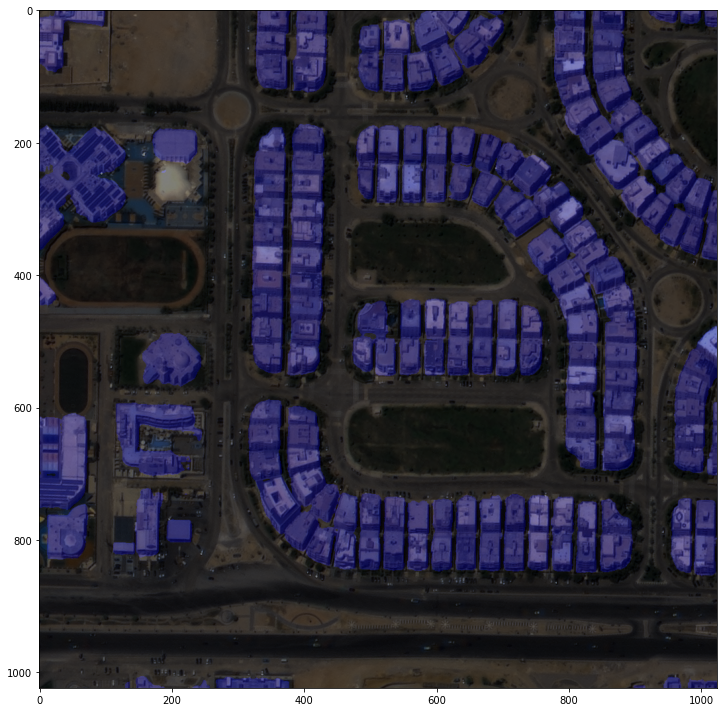

In [20]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


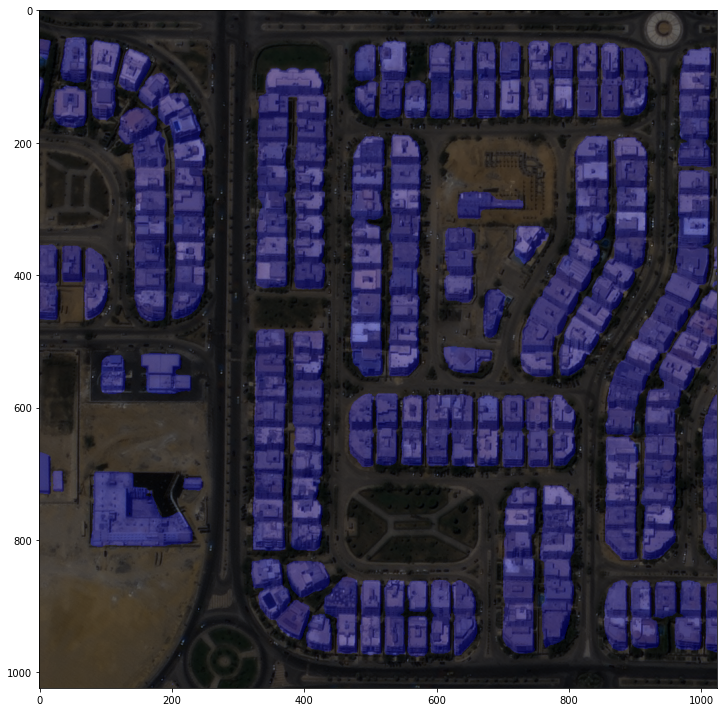

In [21]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


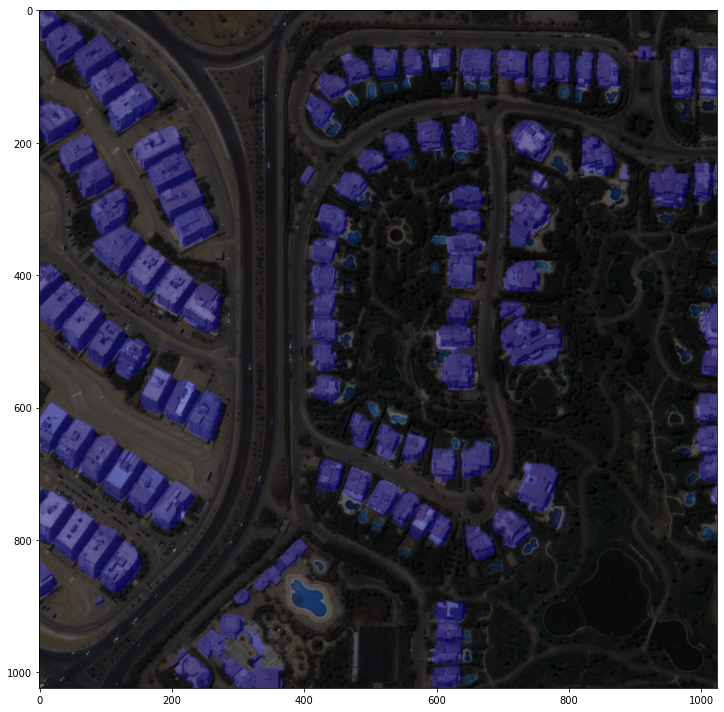

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


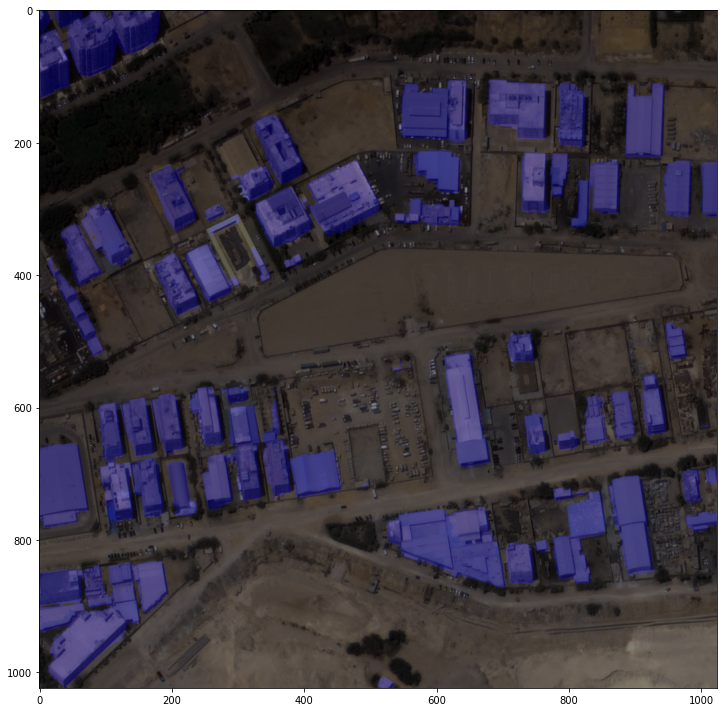

In [23]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_dice_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)